# Tutorial on transfer learning from universal models

In this tutorial, we will improve the universal machine learning potential ANI-1ccx-gelu specifically on CH3NO2 molecule, which will be reflected in improved harmonic frequencies compared with experiment

In [1]:
import mlatom as ml 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Overview of the dataset

We take the datasets from https://doi.org/10.1021/acs.jctc.1c00249. There are 9001 training points with energies and forces at MP2/aug-cc-pVTZ level. 

In [2]:
# prepare the dataset
training_data = ml.data.molecular_database.load('CH3NO2_MP2_avtz.json',format='json')
print('Number of training points: ', len(training_data))

Number of training points:  9001


Text(0, 0.5, 'Number of entries')

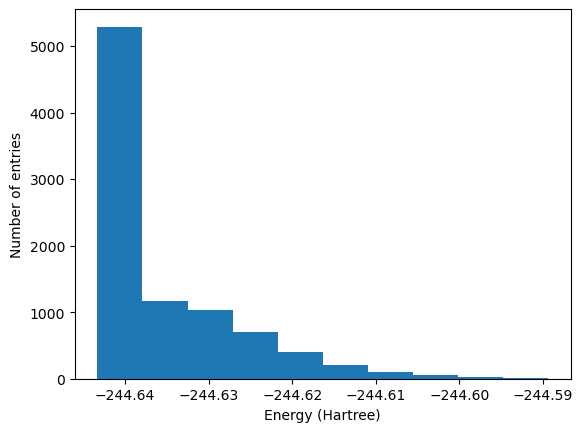

In [3]:
# plot the energy distribution
energies = training_data.get_properties('energy')
plt.hist(energies)
plt.xlabel('Energy (Hartree)')
plt.ylabel('Number of entries')

# Load universal model

In [4]:
ani1ccx_gelu = ml.models.methods(method='ANI-1ccx-gelu')
# ani = ml.models.methods(method='ANI-1ccx')
# ani = ml.models.methods(method='ANI-2x')

If you just want to do transfer learning on one of the universal models, you can use `model_index` to load specific model.

In [5]:
ani1ccx_gelu_cv0 = ml.models.methods(method='ANI-1ccx-gelu', model_index=0)

# Fine tune

There are several parameters we need to care about when transfer learning (though we have default settings in MLatom, you might want to customize the procedure yourself)

### Arguments to pass to `train()`

The arguments available can be found in manual for API about torchani interface. Here several key arguments are listed:

- `reset_energy_shifter [list, bool]`: Control how the self atomic energies will be extracted. By default we will use those extracted from the training data. If set to False, we will use those from pretrained models. If list, values inside will be used as the self atomic energies for scaling. 
- `file_to_save_model [str]`: The file name to save the retrained models. Defaul "{universal model name}_retrained.pt.cv{model index}"
- `verbose [bool or int]`: Control the information printed out when training. 1 will print out training procedure and 2 will print out metrics from training and validation. 
- `hyperparameters [dict]`: Control the training procedure, will explain in detail later.


### Parameters in `hyperparameters`

- `batch_size`: default 8
- `max_epochs`: default 100 for transfer learning
- `fixed_layers`: default 1 and 3 layer are fixed. 

In [6]:
ani1ccx_gelu_cv0.train(
    molecular_database=training_data,
    property_to_learn='energy',
    xyz_derivative_property_to_learn = 'energy_gradients',
    verbose=0,
    hyperparameters={
        'batch_size':512,
        }
)


Start retraining on model 0...


After transfer learning, the `ani1ccx_gelu_cv0` has been replaced by the new model and can be directly used for simulation. We also saved the model file in the current directory either named in the combination of the universal model name plus 'retrained' or the user defined name for the model. You can still load them with torchani interface to do the simulations:

In [7]:
# for loading one model
ani1ccx_gelu_cv0_retrained = ml.models.ani(model_file='ani1ccxgelu_retrained.pt.cv0')

model loaded from ani1ccxgelu_retrained.pt.cv0


# Compare harmonic frequencies

In [8]:
def calculate_harmonic_frequency(
    calculator=None,
    initmol=None,
    opt_program='geometric', # do not use gaussian which currently cannot recognize the retrained method
    freq_program='pyscf',
     
):
    geomopt = ml.simulations.optimize_geometry( 
        model=calculator, 
        initial_molecule=initmol, 
        program=opt_program)
    optmol = geomopt.optimized_molecule
    ml.simulations.freq(
        model=calculator, 
        molecule=optmol,
        program=freq_program,)
    return optmol

In [9]:
# load initial molecule
initmol = ml.data.molecule.from_xyz_file('CH3NO2_init.xyz')

# load universal model
ani1ccx_gelu_original_cv0 = ml.models.methods(method='ANI-1ccx-gelu', model_index=0)

In [10]:
# calculate harmonic frequency
freqmol_anigelu_original = calculate_harmonic_frequency(ani1ccx_gelu_original_cv0, initmol)
freqmol_anigelu_cv0 = calculate_harmonic_frequency(ani1ccx_gelu_cv0, initmol)

In [13]:
# load performance table and check MAE
reference_table = pd.read_csv('CH3NO2_harmonic.csv')
reference_table['ANI-1ccx-gelu-cv0'] = freqmol_anigelu_original.frequencies
reference_table['ANI-1ccx-gelu-cv0-TL'] = freqmol_anigelu_cv0.frequencies

print('MAE (cm-1) of harmonic frequencies compared to MP2:')
mae = abs(reference_table['ANI-1ccx-gelu-cv0'].astype(np.float32)-reference_table['MP2/avtz'].astype(np.float32)).mean()
print(f'ANI-1ccx-gelu-cv0: {mae}')
mae = abs(reference_table['ANI-1ccx-gelu-cv0-TL'].astype(np.float32)-reference_table['MP2/avtz'].astype(np.float32)).mean()
print(f'ANI-1ccx-gelu-cv0-TL: {mae}')


MAE (cm-1) of harmonic frequencies compared to MP2:
ANI-1ccx-gelu-cv0: 26.988115310668945
ANI-1ccx-gelu-cv0-TL: 7.507749557495117


In [14]:
reference_table

Model  MP2/avtz   exp  ANI-1ccx-gelu-cv0  ANI-1ccx-gelu-cv0-TL
0       1     28.91     -         103.767999             64.703797
1       2    478.65   479         513.901562            479.278102
2       3    610.43   599         622.286085            616.218573
3       4    669.67   647         672.347919            672.521882
4       5    940.48   921         965.608931            943.043952
5       6   1127.28  1097        1118.818235           1125.426629
6       7   1148.99  1153        1120.208904           1143.753734
7       8   1412.12  1384        1417.408563           1406.389784
8       9   1430.54  1413        1462.599118           1418.542115
9      10   1491.90  1449        1477.057543           1481.028898
10     11   1502.67  1488        1481.334926           1504.267194
11     12   1745.72  1582        1649.090329           1757.063420
12     13   3115.24  2965        3096.578013           3123.332056
13     14   3221.29  3048        3215.941830           3214.247684
14     15   3247.61  3048        3223.968831           3248.836237